In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

## Input

In [3]:
chain = 'Arbitrum'

In [4]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-07-10.csv'}

## Prep Data

In [6]:
# read data
df = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                 index_col='Date', parse_dates=['Date'])
        .iloc[:-1, :] # drop the last row since it may not be a full day
        .loc[:, ['glpPrice', 'glpPlusFees', 'lpBtcPrice', 'lpEthPrice']]
        .rename(columns={'glpPrice':'glp_price',
                         'glpPlusFees':'glp_plusfees_price', 
                         'lpBtcPrice':'btc_price', 
                         'lpEthPrice':'eth_price'
                        })
     )
df.tail()

,glp_price,glp_plusfees_price,btc_price,eth_price
Date,,,,
2022-07-05,0.7906,1.0951,0.7795,0.6852
2022-07-06,0.8048,1.1096,0.7867,0.7016
2022-07-07,0.8220,1.1272,0.8074,0.7166
2022-07-08,0.8226,1.1281,0.8111,0.7147
2022-07-09,0.8179,1.1235,0.8061,0.7098


In [7]:
last_day = df.index[-1].strftime('%B %d, %Y') # last day available
last_day

'July 09, 2022'

## BuyHold Returns

esGMX rewards are NOT included

In [8]:
def calc_buyhold_ret(start_dt, glp_price_col):
    # Given a start date, calculate buy-n-hold returns of GLP, BTC, and ETH  
    
    glp_buy_price = df.loc[start_dt, glp_price_col] 
    btc_buy_price = df.loc[start_dt, 'btc_price']
    eth_buy_price = df.loc[start_dt, 'eth_price']
        
    # calculate GLP, BTC, and ETH returns
    row = pd.DataFrame(
        dict(glp_ret = df[glp_price_col][-1] / glp_buy_price - 1, # 
             btc_ret = df.btc_price[-1] / btc_buy_price - 1,
             eth_ret = df.eth_price[-1] / eth_buy_price - 1),
        index=[start_dt])
    row.index.name='start_date'
    return row

In [9]:
# unit test
print("{} rewards excluded:".format(reward_token)) 
print(calc_buyhold_ret(df.index[100], "glp_price"), end='\n\n')
print("{} rewards included:".format(reward_token)) 
print(calc_buyhold_ret(df.index[100], "glp_plusfees_price"))

ETH rewards excluded:
            glp_ret  btc_ret  eth_ret
start_date                           
2021-12-09  -0.3587  -0.3285  -0.4587

ETH rewards included:
            glp_ret  btc_ret  eth_ret
start_date                           
2021-12-09  -0.2009  -0.3285  -0.4587


### 1. Revenue Share (70%) Excluded

In [10]:
df_rets = pd.concat(calc_buyhold_ret(start_dt, "glp_price") for start_dt in df.index[:-1])
df_rets.tail()

,glp_ret,btc_ret,eth_ret
start_date,,,
2022-07-04,0.0282,0.0324,0.0272
2022-07-05,0.0346,0.0341,0.0359
2022-07-06,0.0163,0.0246,0.0118
2022-07-07,-0.0050,-0.0016,-0.0095
2022-07-08,-0.0057,-0.0062,-0.0068


In [11]:
# change to long format
df_rets_long = (
    df_rets.reset_index()
        .melt(id_vars='start_date', value_vars=df_rets.columns, var_name='asset', value_name='ret')
        .assign(asset=lambda x: x.asset.str.replace('_ret', '').str.upper())
)
df_rets_long.head()

,start_date,asset,ret
0,2021-08-31,GLP,-0.3147
1,2021-09-01,GLP,-0.3676
2,2021-09-02,GLP,-0.3651
3,2021-09-03,GLP,-0.3738
4,2021-09-04,GLP,-0.3745


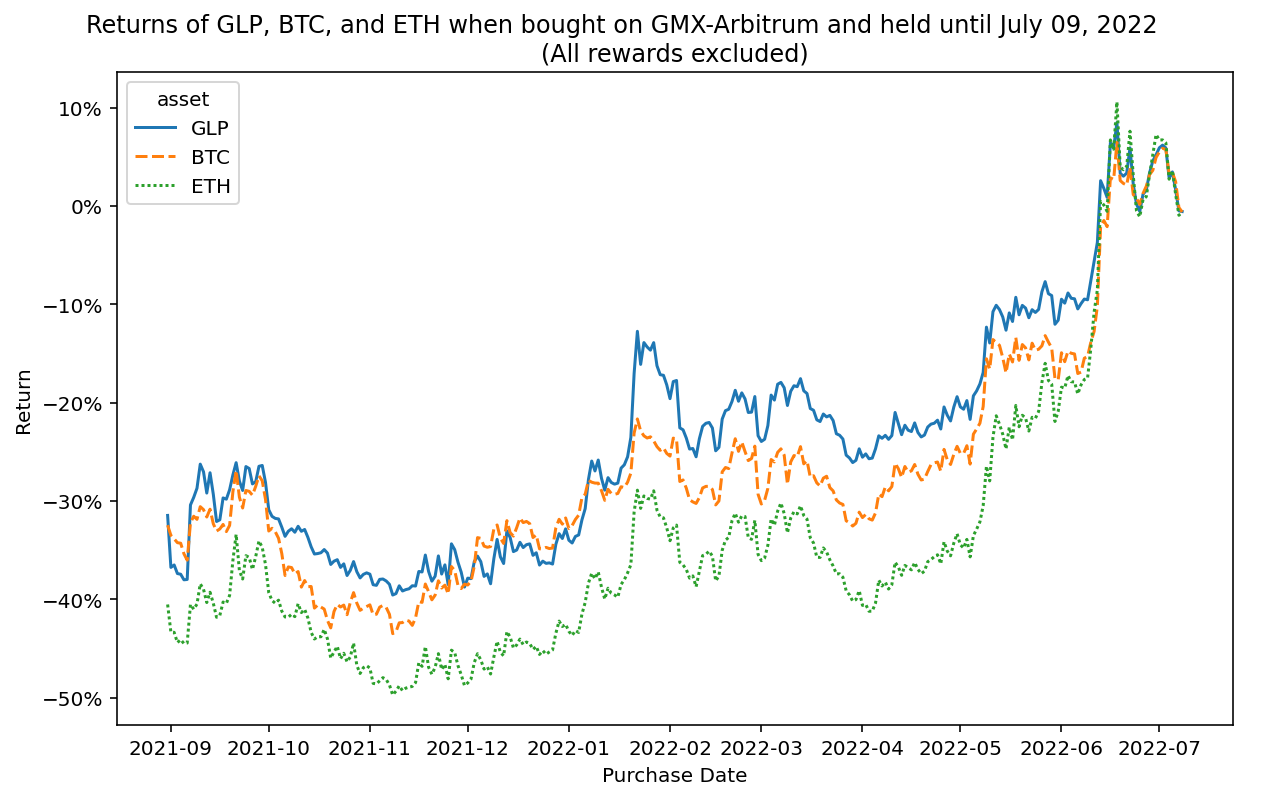

In [12]:
ax = sns.lineplot(data=df_rets_long, x='start_date', y="ret", hue='asset', style='asset')
ax.set(xlabel='Purchase Date', ylabel='Return',
       title='Returns of GLP, BTC, and ETH when bought on GMX-{} and held until {}\
              \n(All rewards excluded)'.format(chain, last_day, reward_token))
ax.yaxis.set_major_formatter(PercentFormatter(1))
fname = 'glp_buyhold_rets_reward_excl.png'
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);

Even without any yields, the price action of GLP price on Arbitrum alone resulted buyhold returns on par with BTC or better, regardless of entry date. This is because ~50% of GLP is in stablecoins and ~50% is in BTC and ETH. It's also because traders' PnL gets factored into GLP price and traders have been net-losing since the beginning.

### 2. Revenue Share (70%) Included

In [13]:
df_rets = pd.concat(calc_buyhold_ret(start_dt, "glp_plusfees_price") for start_dt in df.index[:-1])
df_rets.tail()

,glp_ret,btc_ret,eth_ret
start_date,,,
2022-07-04,0.0218,0.0324,0.0272
2022-07-05,0.0260,0.0341,0.0359
2022-07-06,0.0126,0.0246,0.0118
2022-07-07,-0.0032,-0.0016,-0.0095
2022-07-08,-0.0040,-0.0062,-0.0068


In [14]:
# change to long format
df_rets_long = (
    df_rets.reset_index()
        .melt(id_vars='start_date', value_vars=df_rets.columns, var_name='asset', value_name='ret')
        .assign(asset=lambda x: x.asset.str.replace('_ret', '').str.upper())
)
df_rets_long.head()

,start_date,asset,ret
0,2021-08-31,GLP,-0.0586
1,2021-09-01,GLP,-0.1333
2,2021-09-02,GLP,-0.1306
3,2021-09-03,GLP,-0.1434
4,2021-09-04,GLP,-0.1445


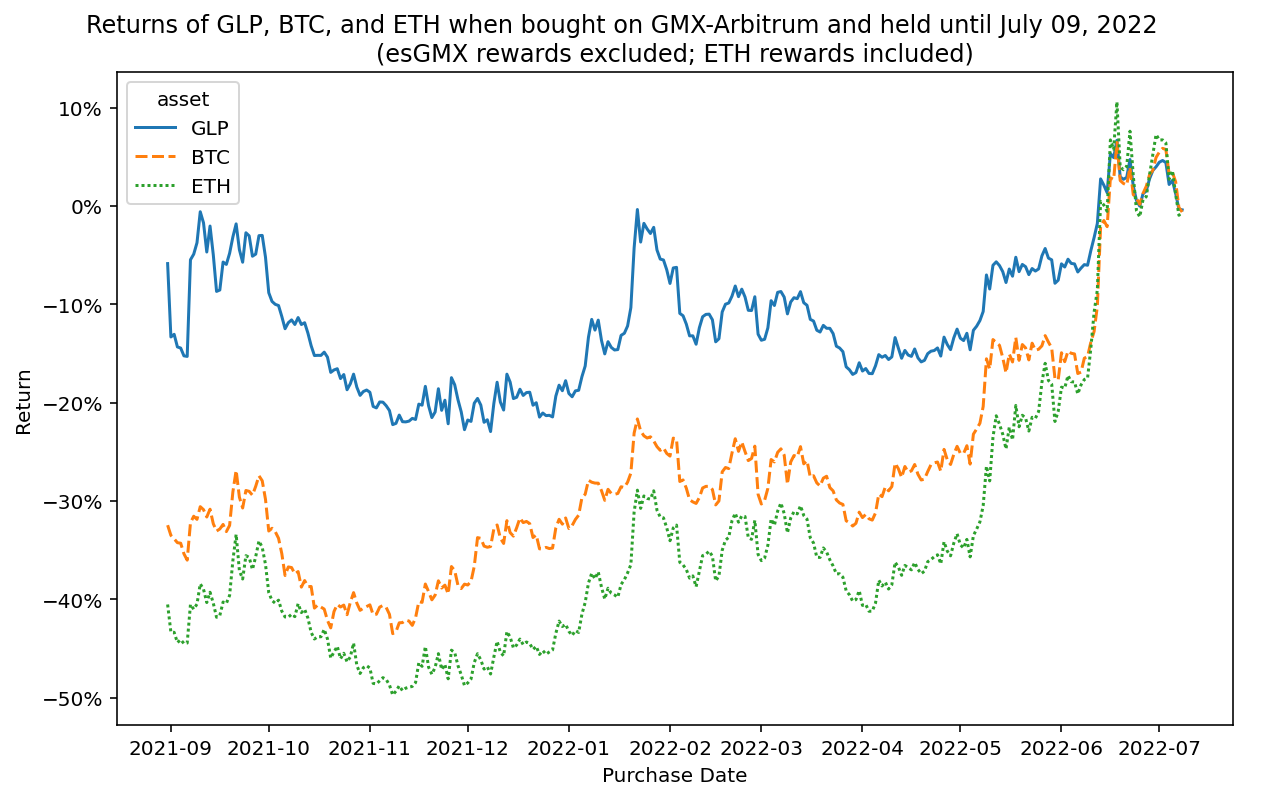

In [15]:
ax = sns.lineplot(data=df_rets_long, x='start_date', y="ret", hue='asset', style='asset')
ax.set(xlabel='Purchase Date', ylabel='Return',
       title='Returns of GLP, BTC, and ETH when bought on GMX-{} and held until {}\
              \n(esGMX rewards excluded; {} rewards included)'.format(chain, last_day, reward_token))
ax.yaxis.set_major_formatter(PercentFormatter(1))
fname = 'glp_buyhold_rets_reward_incl.png'
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);

After including the 70% platform revenue distributed to GLP holders, GLP returns outperformed BTC and ETH most of the time except in the recent month. Hats off to the platform's revenue generation abilities on Arbitrum!

In [16]:
# pick a earlier start date and explain the returns 
a_start_date = pd.to_datetime("2022-01-08")
a_glp_ret, a_btc_ret, a_eth_ret = df_rets.loc[a_start_date,:]
msg1 = "For example, if we bought GLP on {} on {} and sold on {},".format(chain, a_start_date.strftime("%B %d, %Y"), last_day)
msg2 = "our return, after {} rewards and before esGMX rewards, would be {:.2%},".format(reward_token, a_glp_ret)
msg3 = "better than BTC ({:.2%}) or ETH ({:.2%}).".format(a_btc_ret, a_eth_ret)
print(msg1, msg2, msg3)

For example, if we bought GLP on Arbitrum on January 08, 2022 and sold on July 09, 2022, our return, after ETH rewards and before esGMX rewards, would be -11.54%, better than BTC (-28.09%) or ETH (-37.36%).


In [17]:
# pick a recent start date and explain the returns 
a_start_date = pd.to_datetime("2022-06-13")
a_glp_ret, a_btc_ret, a_eth_ret = df_rets.loc[a_start_date,:]
msg1 = "For another example, if we bought GLP on {} on {} and sold on {},".format(chain, a_start_date.strftime("%B %d, %Y"), last_day)
msg2 = "our return, after {} rewards and before esGMX rewards, would be {:.2%},".format(reward_token, a_glp_ret)
msg3 = "better than BTC ({:.2%}) or ETH ({:.2%}).".format(a_btc_ret, a_eth_ret)
print(msg1, msg2, msg3)

For another example, if we bought GLP on Arbitrum on June 13, 2022 and sold on July 09, 2022, our return, after ETH rewards and before esGMX rewards, would be 2.75%, better than BTC (-2.10%) or ETH (0.47%).
